<a href="https://colab.research.google.com/github/AbdulBaseerMohammedKhan/Fellowship.AI/blob/main/fellowship_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem Statement: Perform Sentiment analysis using ULMFiT on Yelp reviews - Polarity and apply the EDA augmentation. Report the performance metrics for before and after augmentation? show examples of data augmentaion?




The dataset is taken from https://www.kaggle.com/irustandi/yelp-review-polarity/version/1?

Useful papers 

https://arxiv.org/pdf/1801.06146.pdf
https://arxiv.org/pdf/1901.11196.pdf

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abdulbaseermohammed","key":"c24dcb245417d0d824f505895f96100d"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:
!kaggle datasets download -d irustandi/yelp-review-polarity

 97% 314M/323M [00:01<00:00, 246MB/s]
100% 323M/323M [00:01<00:00, 214MB/s]


In [5]:
!unzip /content/yelp-review-polarity.zip

Archive:  /content/yelp-review-polarity.zip
  inflating: yelp_review_polarity_csv/readme.txt  
  inflating: yelp_review_polarity_csv/test.csv  
  inflating: yelp_review_polarity_csv/train.csv  
  inflating: yelp_review_polarity_csv/yelp_review_polarity_csv/readme.txt  
  inflating: yelp_review_polarity_csv/yelp_review_polarity_csv/test.csv  
  inflating: yelp_review_polarity_csv/yelp_review_polarity_csv/train.csv  


In [57]:
import pandas as pd
train = pd.read_csv("/content/yelp_review_polarity_csv/train.csv")

In [58]:
#A small subset of the dataset is being used just to test the working of EDA
train = train.head(1000)
train.to_csv("train_1lakh.csv",index = False)

In [59]:
!pip install -U nltk


Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.5)


In [60]:
#!git clone https://github.com/jasonwei20/eda_nlp.git
!git clone https://github.com/AbdulBaseerMohammedKhan/eda_nlp.git

fatal: destination path 'eda_nlp' already exists and is not an empty directory.


In [61]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Performing EDA

In [62]:
!python /content/eda_nlp/code/augment_csv.py --input="/content/train_1lakh.csv"

generated augmented sentences with eda for /content/train_1lakh.csv to /content/eda_train_1lakh.csv with num_aug=9


Finetuning and training on the dataset before EDA

In [63]:
from fastai.text import *

In [106]:
test = pd.read_csv("/content/yelp_review_polarity_csv/test.csv")
test = test.head(1000)
train = pd.read_csv("/content/train_1lakh.csv")
#the test df is also downsized

In [107]:
train.columns =['label', 'Phrase'] 
test.columns =['label', 'Phrase'] 

In [108]:
train.head()
#dataframe before EDA

,label,Phrase
0,2,Been going to Dr. Goldberg for over 10 years. ...
1,1,I don't know what Dr. Goldberg was like before...
2,1,I'm writing this review to give you a heads up...
3,2,All the food is great here. But the best thing...
4,1,Wing sauce is like water. Pretty much a lot of...


In [109]:
train['label'].unique()

array([2, 1])

In [110]:
data = (TextList.from_df(train, cols='Phrase')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=16))
data.show_batch()

idx,text
0,"xxunk . xxmaj he xxunk all options with you and is very xxunk and understanding . xxmaj he does n't judge and asks all the right questions . xxmaj very thorough and wants to be kept in the xxunk on every xxunk of your xxunk health and your life . xxbos i do n't know what xxmaj dr. xxmaj goldberg was like before moving to xxmaj arizona , but let"
1,"i have always loved papa j 's . xxmaj but my recent experience there has changed my mind a bit . \n \n xxmaj from the minute we were seated , we were greeted by a server that was clearly xxunk and did n't know the menu . xxmaj as i said before , i 've been to papa j 's a good handful of times so i know"
2,"to explain everything in detail . i also like that they do n't over charge . i completely trust them to be honest and do the best job possible . xxbos i usually have nothing but good things to say about this place . i 've dealt with xxmaj xxunk and others and have had very good experiences . xxmaj however , this time was very different . i called"
3,"can be quite long ( generally 20 - 30 minutes even for just beer and apps ) . i 've been to the one at the xxmaj xxunk airport as well , but i was xxunk and had free meal tickets , so okay - but - nothing - special pizza from xxmaj rock xxmaj bottom it was . xxmaj since it 's a xxunk national chain , i think"
4,"down the tubes . xxmaj the new xxunk ride they just opened up was okay . i was expecting it to be so much more fun , but literally you just slide down a dark tube into a xxunk room where you just slowly xxunk your way down the middle hole and that was it . \n \n xxmaj there was this one ride where you slide down the"


In [111]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)

In [112]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


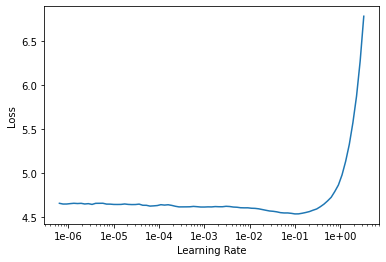

In [113]:
learn.recorder.plot()

In [114]:
#learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))
learn.fit_one_cycle(1)


epoch,train_loss,valid_loss,accuracy,time
0,4.229294,3.962618,0.259605,00:08


In [115]:
learn.save_encoder('fine_tuned_enc')

In [116]:
test_datalist = TextList.from_df(test, cols='Phrase', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='Phrase', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= 'label')
             .add_test(test_datalist)
             .databunch(bs=16))

data_clas.show_batch()

text,target
xxbos xxmaj for our last lunch in xxmaj pittsburgh we decided to return to the xxmaj big xxmaj burrito xxmaj group ; xxmaj eleven was quite good and both xxmaj xxunk and xxmaj pittsburgh xxmaj magazine compared the experience at xxmaj casbah xxunk to that of xxmaj big xxmaj burrito 's xxunk xxunk . xxmaj xxunk a mix of xxmaj mediterranean and xxmaj xxunk xxmaj xxunk xxunk with a bargain,1
"xxbos xxmaj after a morning of xxmaj thrift xxmaj store hunting , a friend and i were thinking of lunch , and he suggested xxmaj emil 's after he 'd seen xxmaj xxunk xxmaj xxunk do a bit on it and had tried it a time or two before , and i had not . xxmaj he said they had a decent xxmaj reuben , but to be prepared to",2
"xxbos xxmaj let 's start this review by saying that when we are at that point , my girlfriend and i will be going to xxmaj xxunk . xxup xxunk xxmaj bank for mine and my xxunk 's xxunk . xxmaj allow me to give you a xxunk xxunk of the issues we encountered when xxunk from xxmaj xxunk 's xxmaj xxunk to be the xxunk in our friends wedding",1
xxbos xxmaj this was the first time for me and my wife at the xxunk xxmaj cafe xxmaj zinho . xxmaj parking in the xxunk area in which the restaurant is located is next to impossible on a busy xxmaj saturday night ; the diner should be prepared to walk a distance to get to the restaurant from where he or she is xxunk able to park . xxmaj the,1
"xxbos xxmaj two meals , on the recommendation of a friend who lives near the place , and after the second trip , i was xxunk to write . ' xxmaj xxunk ' would definitely describe the experiences . \n \n xxmaj on the first trip , i went to try their ( at that xxunk about xxmaj reuben . xxmaj and xxup yet to find a true good",1


In [117]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

In [118]:
learn_classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


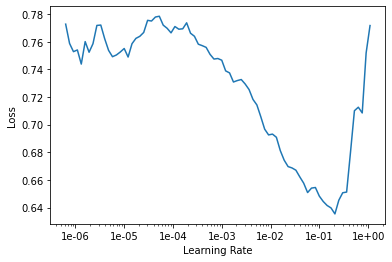

In [119]:
learn_classifier.recorder.plot()

In [120]:
#learn_classifier.fit_one_cycle(5, 2e-2, moms=(0.8,0.7))
learn_classifier.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.577279,0.468479,0.830000,00:05


In [121]:
learn_classifier.show_results()

text,target,prediction
"xxbos i will start by saying we have a nice new deck . xxmaj that is where the good part ends . \n \n xxmaj why two stars if we have a nice deck now ? xxmaj well , it all started in xxmaj may when we had a man named xxmaj al come out and talk to us about the process . xxmaj he was a true xxunk",1,1
"xxbos a few years ago , i lost my partner and love of my life in a xxunk xxunk . xxmaj while xxunk with my xxunk xxunk and having xxunk getting back into life as i once knew it , my xxunk xxunk suggested that i "" help something else "" in order to help myself feel better . xxmaj we decided that since i was an animal lover i",2,1
"xxbos i have tried xxmaj whole xxmaj foods recently even after hearing about the attitude of the xxunk , hipster employees and xxunk , xxunk - xxunk customers that will literally push you aside a turn their xxunk up at you a million times . xxmaj the xxunk were true ! ! ! \n \n xxmaj even though i was only there one time , first xxunk are a",1,1
"xxbos xxmaj incredible experience up here , i would have to say that this goes down as one of my most memorable dining experiences in xxmaj pittsburgh for a number of reasons . i personally love this style of xxmaj italian cooking . xxmaj sicilian , so folks who are not familiar should take look at their menu online before coming because it might catch you off guard , it",2,2
"xxbos xxmaj when did xxmaj dave and xxmaj buster 's become a xxunk ? ? xxmaj everywhere you look , there are signs that say kids must be accompanied by an adult , but apparently no one was xxunk that at xxup 6pm on a xxmaj saturday . i could n't even walk through the place without someone shoving me . xxup xxunk ! \n i get that xxmaj",1,1


In [122]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = np.argmax(preds, axis =1)

In [123]:
labels = np.argmax(preds, axis =1).double()

In [124]:
test_y1 = labels.numpy().astype(int)+1

In [125]:
test = test.label.values.astype(int)

In [126]:
from sklearn.metrics import accuracy_score
print("Accuracy before EDA:   ",accuracy_score(test,test_y1))

Accuracy before EDA:    0.776


Finetuning and training on the dataset after EDA

In [85]:
train = pd.read_csv("/content/eda_train_1lakh.csv")

In [86]:
test = pd.read_csv("/content/yelp_review_polarity_csv/test.csv")
test = test.head(1000)

In [87]:
train.columns =['label', 'Phrase'] 
test.columns =['label', 'Phrase'] 

In [88]:
train.head()

,label,Phrase
0,1,unfortunately the frustration business office ...
1,1,unfortunately the frustration of being dr gold...
2,1,unfortunately the frustration of being dr gold...
3,1,unfortunately the frustration of being dr gold...
4,1,unfortunately the frustration of being dr gold...


In [89]:
train.shape

(10009, 2)

In [90]:
data = (TextList.from_df(train, cols='Phrase')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=16))
data.show_batch()

idx,text
0,other doctors and i just do nt get it you have office workers you have patients with medical needs why is nt anyone answering the call up its incomprehensible and not work the aggravation its with regret that i spirit that i have to give dr goldberg superstar xxbos unfortunately the frustration of being dr goldbergs patient is a repeat of the experience answer had with into many other doctors
1,nt good at all i aboveboard would have sooner had a fish sandwich from mcdonalds that nox the server neer did anything to try to make our see xxunk he knew we were nt felicitous but neer bid anything such as dessert on the house i m not looking for a handout but our see was just plain awful that nox the rib neer really tranquilize apologized for the mistake
2,number on the check news report type a match the account number on the screen why associate in nursing should it those computers are always making mistakes n nnow that we have verified that all the information is correct we can process simply the payment the customer simply cost will be so happy that we get along did nt have to bother them with any silly questions n n ni
3,d think a comedy club should like if you watch enough tv the interior is clean the seats are comfortable and its an ok atmosphere to see a show and laugh n nits too small however to attract many of the best acts which limits its ability to ever become the central hub for pittsburgh comedy most of the big names that have recently come through pittsburgh jim gaffigan louis
4,excites me this place is a dud guess what chicagoans do nt know how to eat hot dogs either xxbos i really do nt know why be bother with chain restaurants anymore gourmet that i however has matured nthe i no longer think chicken fingers and french fries are now cuisine doing really ca nt find dressing drizzling eat salad a place like this n nmy husband and i too


In [91]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)

In [92]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


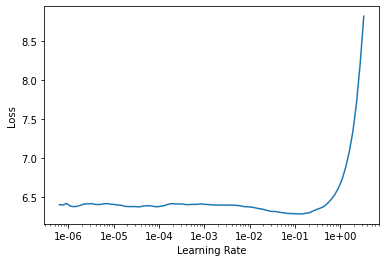

In [93]:
learn.recorder.plot()

In [94]:
#learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))
learn.fit_one_cycle(1)


epoch,train_loss,valid_loss,accuracy,time
0,4.829789,4.716561,0.211081,01:19


In [95]:
learn.save_encoder('fine_tuned_enc')

In [96]:
test_datalist = TextList.from_df(test, cols='Phrase', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='Phrase', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= 'label')
             .add_test(test_datalist)
             .databunch(bs=16))

data_clas.show_batch()

text,target
xxbos for our last lunch in pittsburgh dental plate we decided to return to the big burrito group eleven was quite good and both gayot broiled and pittsburgh magazine compared the experience at casbah favorably to that of big burritos crown jewel citing a mix of mediterranean and garden xxunk northern african influences foresighted with a along bargain piccola gusto menu for lunch and the option for indoor or al,1
xxbos chemical group for our last lunch in pittsburgh we decided to return to the big burrito group eleven was wa quite good and both gayot and pittsburgh magazine compared dehydrated the experience at casbah favorably extend to that of big burritos crown jewel citing a mix of mediterranean and northern earlier african influences with a bargain piccola gusto menu for lunch and the option for indoor or al fresco,1
xxbos lets start this review conjoin by saying that when we are at that point my girlfriend and i will be inform pine tree state going to jos a tux bank for resolution mine and my groomsmans suits allow me to give you a numbered breakdown of the issues we encountered when renting following from mens wearhouse to be the groomsmen valet de chambre in our friends wedding n n,1
xxbos after a fresh a thrift store hunting a friend and mapquest were thinking of lunch and he good bread after he d seen chris sebak do a bit on it and had tried it a time and two before but i had not he said they had a nuts on tasty came be prepared to step back in time n nwell seeing as how i m kind of addicted,2
xxbos i will be by usually we circles a nice digging deck that is where the when part hours n th two stars if that have a week deck now well it all started in may n we had a man named al come survey and ni salesman us about the process he a a true to ill tell was we not a i shooter takes an excited i that,1


In [97]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

In [98]:
learn_classifier.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


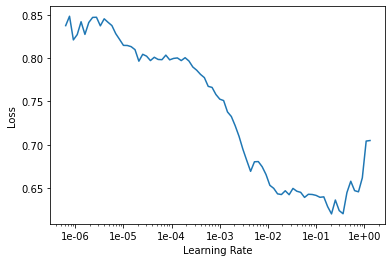

In [99]:
learn_classifier.recorder.plot()

In [100]:
#learn_classifier.fit_one_cycle(5, 2e-2, moms=(0.8,0.7))
learn_classifier.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.420173,0.276856,0.897051,00:47


In [101]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = np.argmax(preds, axis =1)

In [102]:
labels = np.argmax(preds, axis =1).double()

In [103]:
test_y = labels.numpy().astype(int)+1

In [104]:
test = test.label.values.astype(int)

In [105]:
from sklearn.metrics import accuracy_score
print("Accuracy after EDA:  ",accuracy_score(test,test_y))

Accuracy after EDA:   0.844


In [127]:
print("Accuracy before EDA:  ",accuracy_score(test,test_y1))

Accuracy before EDA:   0.776
